# Construct GAN and structure
---
Construct GAN, define training loop with multithreaded approach, and practice using industry standard terminal initialization commands

In [161]:
### - IMPORTS - ###
from PIL import Image
import numpy as np
import glob
from keras.preprocessing.image import ImageDataGenerator
from multiprocessing.dummy import Pool as TP
import keras.preprocessing.image
import cv2 as cv
import os
import random
### - other data augmentation imports - ### (if needed)
### - Imports - ###
import math
import numpy as np
import sklearn as sk #general imports, initial data preprocessing/OS stuff
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import torch as T
import torch.nn as nn
import torch.optim as optim #Neural network imports, multiply data etc
from torchvision.transforms import ToTensor
import torchvision.models as models
import torchvision
import torch.nn.functional as F #Neural Network used in Comp4660 at ANU

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.metrics import confusion_matrix #analysis

from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

from Utils.NetworkHelpers import EqualizedLR_Conv2d, Pixel_norm, Minibatch_std

### - Other global variables - ###
LOVTV = [15, 26, 66] ##Training values to leave out

img_folder = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/'

NS = '/Sample-'

image_format = 'RGB'

imsize = 4

multiplication_factor = 20

num_channels=3
kernal=4
s=2
p=1

In [142]:
### - Get image Paths - ###
assert(os.path.exists(DFP + str(1) + ".jpg"))
rawimgf = sorted(glob.glob(DFP + '*.jpg', recursive = True))
### - image names - ###
imnames = [i.split('/')[-1].split("t")[-1][1:] for i in rawimgf]

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
T.manual_seed(manualSeed)

Random Seed:  999


In [143]:
class ImageDataset(Dataset):
    def __init__(self,img_folder,names, transform):
        self.transform = transform
        self.image_names = names #Predetermined dataset
        self.img_folder=img_folder
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self,index):
    
        image=cv.imread(self.img_folder+self.image_names[index])
        image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
        image=self.transform(image)
        
        return image

    
### - Global data loader Vars - ###
norms = (0.5,0.5,0.5), (0.5,0.5,0.5)
train_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((imsize, imsize)),
                transforms.RandomHorizontalFlip(p=0.5)])

# CUDA for PyTorch
use_cuda = T.cuda.is_available()
device = T.device("cuda:0" if use_cuda else "cpu")
T.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 32,
          'shuffle': True}

train_dataset=ImageDataset(img_folder,imnames, train_transform)

In [144]:
train_dl = DataLoader(train_dataset, **params)

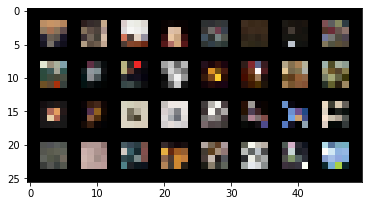

In [145]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def imshow(inp, title=None):
    """imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
# Get a batch of training data
images = next(iter(train_dl))

# Make a grid from batch
output = torchvision.utils.make_grid(images)

imshow(output)

In [146]:
### - Send data to the correct device - ###
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DDL():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
    
    def __len__(self):
        return len(self.dl)

In [147]:
print(device)

cuda:0


In [148]:
trainddl = DDL(train_dl, device)

In [163]:
### - Train help functions - ###
#Cyclic LR Scheduler
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

factors = [1, 1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32]

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
class fRGB(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.cvt = EqualizedLR_Conv2d(in_c, out_c, kernal_size=(1,1), stride=(1,1))
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        return self.relu(x)
        
class tRGB(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.cvt = EqualizedLR_Conv2d(in_c, out_c, kernal_size=(1,1), stride=(1,1))
        
    def forward(self, x):
        return(self.cvt(x))

In [166]:
#Discriminator block
class D_Cell(nn.Module):
    def __init__(self, in_c, out_c, sb=0):
        self.sb = sb
        super().__init__()
        
        #Define network structure
        if sb == 1: #sb is your structure for the block
            #Set structure
            self.frgb = fRGB(in_c, out_c)
            
            self.econv1 = EqualizedLR_Conv2d(in_c, out_c, kernel_size=(3,3), stride=(1,1), padding=(1,1)) #Initial block a (alpha)
            
            self.econv2 = EqualizedLR_Conv2d(out_c, out_c, kernel_size=(4,4), stride=(1,1))
            
            self.outlayer = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        elif sb == 2:
            self.ds = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
            self.frgb = fRGB(in_c, out_c)                                                                 #initial block b (1-alpha)
        elif sb == 0:
            #Set normal cell structure
            self.econv1 = EqualizedLR_Conv2d(in_c, out_c, kernel_size=(3,3), stride=(1,1), padding=(1,1)) #Initial block a (alpha)
            
            self.econv2 = EqualizedLR_Conv2d(out_c, out_c, kernel_size=(4,4), stride=(1,1))
            
            self.outlayer = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        else:
            self.mbstd = Minibatch_std()
            self.econv2 = EqualizedLR_Conv2d(out_c, out_c, kernel_size=(4,4), stride=(1,1)) #output block
            self.finish = nn.Sequential(nn.Flatten(), nn.Linear(out_c, out_c) ,nn.LeakyReLU(0.2, inplace=True), nn.Linear(out_c, 1))
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        ### - Account for each discriminator block archetype - ###
        if self.sb == 0 or self.sb == 1:
            if self.sb == 1:
                x = self.frgb(x)
                x = self.relu(x)
            x = self.econv1(x)
            x = self.relu(x)
            
            x = self.econv(x)
            x = self.relu(x)
            
            x = self.outlayer(x)
        elif self.sb == 2:
            x = self.ds(x)
            x = self.frgb(x)
            x = self.relu(x)
        else:
            x = self.mbstd(x)
            x = self.econv2(x)
            x = self.relu(x)
            x = self.finish(x)
        return x
            
#Generator Block

class G_Cell(nn.Module):
    def __init__(self, in_c, out_c, sb=0):
        self.sb = sb
        super().__init__()
        
        #Define network structure
        if sb == 0:
            self.us = nn.Upsample(scale_factor=2, mode='nearest') #Base block (standard cell)
            self.conv1 = EqualizedLR_Conv2d(in_c, out_c, kernel_size=(3,3), stride=(1,1), padding='same')
            self.conv2 = EqualizedLR_Conv2d(in_c, out_c, kernel_size=(3,3), stride=(1,1), padding='same')
        elif sb == 1:
            self.dense = nn.Linear(in_c) #Our first initial training layer
            self.conv1 = EqualizedLR_Conv2d(in_c, out_c, kernel_size=(3,3), stride=(1,1), padding='same')
            
        
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.pn = Pixel_norm()
        
    def forward(self, x):
        if self.sb == 0:
            x = self.us(x)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.pn(x)
            x = self.conv2(x)
            x = self.relu(x)
            x = self.pn(x)
        elif self.sb == 1:
            x = self.pn(x)
            x = self.dense(x)
            x = self.relu(x)
            x = self.pn(x)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.pn(x)
        return x
            

# Network Structure and Basic Theory

---

Each network will progressively need to grow more and more in order to upscale the images while keeping each of the dims the same for upscaling it.
Therefore to accurately train this model we construct it in such a way that we may output a 1 megapixel image.

This involves defining the structure for the overall network once it is finished and including a depth index variable that will be increased in training.

In [158]:
#Discriminator#
class G(nn.Module):
    def __init__(self, ls, out):
        """
        ls is latent size
        out is desired output resolution
        build structure iteratively
        """
        super().__init()
        self.depth = 1 #Current indexing
        self.alpha = 1 #Fade value
        self.incalpha = 0 #Value to increment alpha by
        
        self.trgb = tRGB(ls, 3) #torgb value
        self.us = nn.Upsample(scale_factor=2, mode='nearest')
        self.net = nn.ModuleList([G_Cell(ls, ls, sb=1)])
        self.rgbs = nn.ModuleList([tRGB(latent_size, 3)])
        
        #Add all standard blocks
        for i in range(2, int(np.log2(out))):
            ### - trick is to decrease the latent vector as well for each of the higher level blocks - ###
            if i < 7: 
                in_c = 1024
                out_c = 1024
            else:
                in_c = int(1024 / 2**(i-7))
                out_c = int(1024 / 2**(i-7))
            self.net.append(G_Cell(in_c, out_c))
            self.rgbs.append(tRGB(out_c, 3))
            
    def forward(self, x):
        for cell in self.net[:self.depth-1]:
            x = cell(x)
        out = self.net[self.depth-1](x)
        crgb = self.rgbs[self.depth-1](out)
        if self.alpha < 1:
            xprev = self.us(x)
            rgbprev = self.rgbs[self.depth-2](xprev)
            crgb = self.alpha * (rgbprev) + (1-self.alpha)*(crgb)
        return crgb
    def inc_depth(self, iters):
        self.incalpha = 1/iters
        self.alpha = 1/iters
        self.depth += 1

Sequential(
  (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(4, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (4): Sigmoid()
)


In [153]:
#Generator#


Sequential(
  (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
